# Part 0: Set up google drive environment

In [107]:
# install pydrive to load data
!pip install -U -q PyDrive

In [108]:
pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [115]:
id = "1konOLheBhUiLfDK67L1WtANCYyS5thB8"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('vehicles.csv')

In [116]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import urllib
import requests

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# Data Pre-processing

In [117]:
vehicle_df = pd.read_csv('vehicles.csv')
vehicle_df.head(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [118]:
drop_columns = ['id','url', 'region', 'region_url', 'VIN', 'description', 'county','image_url', 'lat','long', 'posting_date']
# drop_columns = ['id','url', 'region', 'region_url', 'VIN', 'description', 'county','image_url', 'lat','long', 'posting_date', 'model']
## dropped model
vehicle_df = vehicle_df.drop(columns = drop_columns)
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 48.9+ MB


In [119]:
# year range (1960, 2021)
vehicle_df.drop(vehicle_df[vehicle_df.year < 1960].index, inplace = True)
vehicle_df.drop(vehicle_df[vehicle_df.year > 2021].index, inplace = True)

# price range (100, 100,000)
vehicle_df.drop(vehicle_df[vehicle_df.price < 100].index, inplace = True)
vehicle_df.drop(vehicle_df[vehicle_df.price > 100000].index, inplace = True)

# delete missing vals
vehicle_df = vehicle_df.dropna(axis = 0, subset = ['year', 'manufacturer', 'model', 'fuel', 'odometer', 'transmission'])
# vehicle_df = vehicle_df.dropna(axis = 0, subset = ['year', 'manufacturer', 'fuel', 'odometer', 'transmission'])

# imputate with mode
vehicle_df['title_status'].fillna(vehicle_df['title_status'].mode()[0], inplace = True)
vehicle_df['drive'].fillna(vehicle_df['drive'].mode()[0], inplace = True)
vehicle_df['size'].fillna(vehicle_df['size'].mode()[0], inplace = True)
vehicle_df['type'].fillna(vehicle_df['type'].mode()[0], inplace = True)
vehicle_df['paint_color'].fillna(vehicle_df['paint_color'].mode()[0], inplace = True)
vehicle_df['condition'].fillna(vehicle_df['condition'].mode()[0], inplace = True)
vehicle_df['cylinders'].fillna(vehicle_df['cylinders'].mode()[0], inplace = True)

vehicle_df['odometer'] = (vehicle_df['odometer']).astype(int)
vehicle_df.drop_duplicates(inplace = True, ignore_index = True)

In [120]:
vehicle_df.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

## Add Climate feature

In [121]:
us_state_to_abbrev = {
"Alabama": "AL",
"Alaska": "AK",
"Arizona": "AZ",
"Arkansas": "AR",
"California": "CA",
"Colorado": "CO",
"Connecticut": "CT",
"Delaware": "DE",
"Florida": "FL",
"Georgia": "GA",
"Hawaii": "HI",
"Idaho": "ID",
"Illinois": "IL",
"Indiana": "IN",
"Iowa": "IA",
"Kansas": "KS",
"Kentucky": "KY",
"Louisiana": "LA",
"Maine": "ME",
"Maryland": "MD",
"Massachusetts": "MA",
"Michigan": "MI",
"Minnesota": "MN",
"Mississippi": "MS",
"Missouri": "MO",
"Montana": "MT",
"Nebraska": "NE",
"Nevada": "NV",
"New Hampshire": "NH",
"New Jersey": "NJ",
"New Mexico": "NM",
"New York": "NY",
"North Carolina": "NC",
"North Dakota": "ND",
"Ohio": "OH",
"Oklahoma": "OK",
"Oregon": "OR",
"Pennsylvania": "PA",
"Rhode Island": "RI",
"South Carolina": "SC",
"South Dakota": "SD",
"Tennessee": "TN",
"Texas": "TX",
"Utah": "UT",
"Vermont": "VT",
"Virginia": "VA",
"Washington": "WA",
"West Virginia": "WV",
"Wisconsin": "WI",
"Wyoming": "WY",
"District of Columbia": "DC",
"American Samoa": "AS",
"Guam": "GU",
"Northern Mariana Islands": "MP",
"Puerto Rico": "PR",
"United States Minor Outlying Islands": "UM",
"U.S. Virgin Islands": "VI"
}

In [122]:
## extract data from 1960 to 2021 through Jan to Dec
temperatureData = None
for i in range(1, 13):  # for each month in the same state
  print("Processing Month number: " + str(i))
  for j in range(1, 53):   # for each state in US
    link = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/"+ str(j) +"/tavg/1/" + str(i) + "/1960-2021.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000"
    ret = requests.get(link).status_code
    if (ret != 200):
      continue
    else:
      tempfile = pd.read_csv(link)
      state = tempfile.columns.tolist()[0]
      state_abbrev = us_state_to_abbrev[state].lower()
      month = tempfile.columns.tolist()[2].lstrip()
      tempfile.columns = ["Date", "Temperature", "Anomaly"]
      state_data = tempfile[4:]
      state_data['Month'] = month
      state_data['State'] = state 
      state_data['State_abbrev'] = state_abbrev
      state_data['Year'] = state_data['Date'].str[0:4]
      temperatureData = pd.concat([temperatureData, state_data])


Processing Month number: 1
Processing Month number: 2
Processing Month number: 3
Processing Month number: 4
Processing Month number: 5
Processing Month number: 6
Processing Month number: 7
Processing Month number: 8
Processing Month number: 9
Processing Month number: 10
Processing Month number: 11
Processing Month number: 12


In [123]:
temperatureData

,Date,Temperature,Anomaly,Month,State,State_abbrev,Year
4,196001,44.5,-0.6,January,Alabama,al,1960
5,196101,39.2,-5.9,January,Alabama,al,1961
6,196201,42.6,-2.5,January,Alabama,al,1962
7,196301,39.1,-6.0,January,Alabama,al,1963
8,196401,42.4,-2.7,January,Alabama,al,1964
...,...,...,...,...,...,...,...
61,201712,19.1,15.4,December,Alaska,ak,2017
62,201812,9.1,5.4,December,Alaska,ak,2018
63,201912,6.7,3.0,December,Alaska,ak,2019
64,202012,10.6,6.9,December,Alaska,ak,2020


In [124]:
all_states = vehicle_df['state'].unique().tolist()

In [125]:
np.intersect1d(vehicle_df['state'].unique(), temperatureData['State_abbrev'].unique())

array(['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'ia',
       'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn',
       'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny',
       'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va',
       'vt', 'wa', 'wi', 'wv', 'wy'], dtype=object)

In [126]:
set(vehicle_df['state'].unique())^set(temperatureData['State_abbrev'].unique())

{'dc', 'hi'}

NCEI didn't record temperature information for state DC and HI.

In [127]:
temperatureData = temperatureData.astype({'Temperature': 'float', 'Anomaly': 'float'})

In [128]:
temperatureData.dtypes

Date             object
Temperature     float64
Anomaly         float64
Month            object
State            object
State_abbrev     object
Year             object
dtype: object

In [129]:
## use Jan and Jul temperature info to define cold, temperate and warm states
month_summary = temperatureData.groupby(['Month','State_abbrev'])['Temperature'].mean().reset_index(name ='Avg_temperature').round(1)
temp_month = ['January', 'July']
sel_month_summary = month_summary [month_summary.Month.isin(temp_month)]
## select cold state
c1 = sel_month_summary[(sel_month_summary.Avg_temperature <= 26.6) & (sel_month_summary.Month == 'January')]['State_abbrev']
c2 = sel_month_summary[(sel_month_summary.Avg_temperature <= 64.4) & (sel_month_summary.Month == 'July')]['State_abbrev']
## select warm state
w1 = sel_month_summary[(sel_month_summary.Avg_temperature >= 55.4) & (sel_month_summary.Month == 'January')]['State_abbrev']
w2 = sel_month_summary[(sel_month_summary.Avg_temperature >= 80.6) & (sel_month_summary.Month == 'July')]['State_abbrev']

In [130]:
warm_states = list(set(w1) | set(w2))
warm_states.append('hi')
cold_states = list(set(c1) | set(c2))
temperate_states = list(set(all_states)^(set(warm_states) | set(cold_states)))

Add temperature info to the dataset

In [131]:
vehicle_df.loc[vehicle_df['state'].isin(warm_states), 'Climate'] = 'Warm' 
vehicle_df.loc[vehicle_df['state'].isin(cold_states), 'Climate'] = 'Cold'
vehicle_df.loc[vehicle_df['state'].isin(temperate_states), 'Climate'] = "Temperate"

# Exploratory Data Analysis (EDA) using pandas profiling

In [132]:
vehicle_df['price'].value_counts()

4500     2282
3500     2183
6995     2120
5500     2119
6500     2079
         ... 
27168       1
4372        1
14693       1
20753       1
19853       1
Name: price, Length: 14879, dtype: int64

In [133]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256298 entries, 0 to 256297
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         256298 non-null  int64  
 1   year          256298 non-null  float64
 2   manufacturer  256298 non-null  object 
 3   model         256298 non-null  object 
 4   condition     256298 non-null  object 
 5   cylinders     256298 non-null  object 
 6   fuel          256298 non-null  object 
 7   odometer      256298 non-null  int64  
 8   title_status  256298 non-null  object 
 9   transmission  256298 non-null  object 
 10  drive         256298 non-null  object 
 11  size          256298 non-null  object 
 12  type          256298 non-null  object 
 13  paint_color   256298 non-null  object 
 14  state         256298 non-null  object 
 15  Climate       256298 non-null  object 
dtypes: float64(1), int64(2), object(13)
memory usage: 31.3+ MB


In [134]:
vehicle_df.describe()

,price,year,odometer
count,256298.000000,256298.000000,2.562980e+05
mean,17516.061460,2010.901860,1.016355e+05
std,13986.229062,8.287119,1.770696e+05
min,100.000000,1960.000000,0.000000e+00
25%,6850.000000,2007.000000,4.246000e+04
50%,13987.000000,2013.000000,9.300000e+04
75%,25000.000000,2017.000000,1.400000e+05
max,100000.000000,2021.000000,1.000000e+07


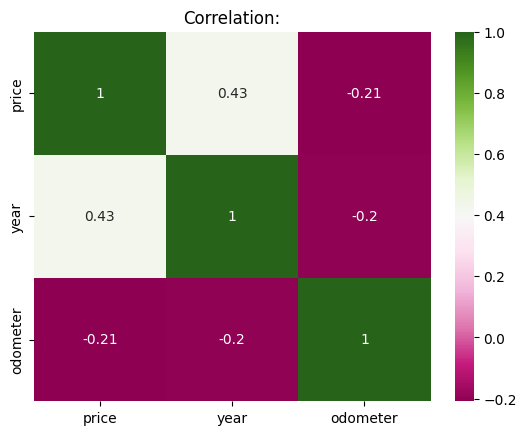

In [135]:
sns.heatmap(vehicle_df.corr(), annot = True, cmap="PiYG")
plt.title("Correlation:")
plt.show() # price related categorical variables includes year, odometer, and age

In [30]:
pp.ProfileReport(vehicle_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Preparing data

In [136]:
target = 'price'
y = vehicle_df[target]   # equals to y
X = vehicle_df.drop([target], axis = 1) # equals to X
valid_part = 0.3

In [137]:
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')].tolist()
cat_cols = X.columns[X.dtypes == 'O'].tolist()

ordinal_cols = ['condition', 'Climate']
label_cols = ['state', 'manufacturer', 'model']
# label_cols = ['state', 'manufacturer']
onehot_cols = [ele for ele in cat_cols if ele not in ordinal_cols]
onehot_cols = [ele for ele in onehot_cols if ele not in label_cols]

In [138]:
train0, test0, train_target0, test_target0 = train_test_split(X, y, test_size = .2, random_state = 0)

print('training data has ' + str(train0.shape[0]) + ' observation with ' + str(train0.shape[1]) + ' features')
print('test data has ' + str(test0.shape[0]) + ' observation with ' + str(test0.shape[1]) + ' features')

training data has 205038 observation with 15 features
test data has 51260 observation with 15 features


In [139]:
# boosting
train0b = train0
train_target0b = train_target0
# Synthesis valid as test for selection models (how to use this part)
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size = valid_part, random_state = 0)

In [140]:
## categorical features encoding
## label encoding
categorical_cols = label_cols

for col in categorical_cols:
  print(col)
  enc_le = LabelEncoder()
  # enc_le.fit(train0[col])
  enc_le.fit(X[col])
  train0[col] =  enc_le.transform(train0[col])
  test0[col] =  enc_le.transform(test0[col])

  trainb[col] =  enc_le.transform(trainb[col])
  testb[col] =  enc_le.transform(testb[col])

state
manufacturer
model


In [141]:
## Ordinal encoding
categories = ['condition', 'Climate']

for col in categories:
  col = [col]
  enc_oe = OrdinalEncoder()
  enc_oe.fit(train0[categories])
  train0[categories] =  enc_oe.transform(train0[categories])
  test0[categories] =  enc_oe.transform(test0[categories])

  enc_oe.fit(trainb[categories])
  trainb[categories] =  enc_oe.transform(trainb[categories])
  testb[categories] =  enc_oe.transform(testb[categories])


In [142]:
onehot_cols

['cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color']

In [143]:
## One hot encoding
def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = onehot_cols
for col in categories:
  col = [col]
  enc_ohe = OneHotEncoder()
  enc_ohe.fit(train0[col])
  train0 = OneHotEncoding(train0, enc_ohe, col)
  test0 = OneHotEncoding(test0, enc_ohe, col)

  enc_ohe.fit(trainb[col])
  trainb = OneHotEncoding(trainb, enc_ohe, col)
  testb = OneHotEncoding(testb, enc_ohe, col)




In [144]:
train0

,year,manufacturer,model,condition,odometer,state,Climate,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,2013.0,13,8996,2.0,148444,48,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2013.0,21,14022,0.0,144272,40,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018.0,6,21121,2.0,77596,16,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011.0,13,7081,0.0,97347,42,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2019.0,16,13929,2.0,72230,31,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205033,2016.0,7,17852,2.0,70919,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
205034,2014.0,17,7287,2.0,44043,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
205035,2011.0,30,2975,2.0,151802,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
205036,1970.0,7,4160,2.0,20000,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [145]:
test0

,year,manufacturer,model,condition,odometer,state,Climate,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,1997.0,36,14052,2.0,144585,26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011.0,7,5831,2.0,30237,9,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2006.0,33,644,0.0,169953,12,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2007.0,38,14644,3.0,64950,38,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1997.0,38,18496,2.0,245000,47,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51255,2012.0,7,6077,2.0,94749,38,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51256,2017.0,20,20484,3.0,60840,36,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51257,2013.0,10,10982,2.0,164329,23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51258,1976.0,13,12989,2.0,78000,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Feature Standardize/Normalization

In [146]:
# feature standardization based on mean and sd
scaler = StandardScaler()
scaler.fit(train0[num_cols])
train0[num_cols] = scaler.transform(train0[num_cols])
test0[num_cols] = scaler.transform(test0[num_cols])

scaler.fit(trainb[num_cols])
trainb[num_cols] = scaler.transform(trainb[num_cols])
testb[num_cols] = scaler.transform(testb[num_cols])

In [85]:
train0

,year,manufacturer,model,condition,odometer,state,Climate,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,0.253820,13,8996,2.0,0.259272,48,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.253820,21,14022,0.0,0.236121,40,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.856847,6,21121,2.0,-0.133872,16,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012609,13,7081,0.0,-0.024271,42,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.977452,16,13929,2.0,-0.163648,31,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205033,0.615636,7,17852,2.0,-0.170923,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
205034,0.374425,17,7287,2.0,-0.320061,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
205035,0.012609,30,2975,2.0,0.277905,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
205036,-4.932213,7,4160,2.0,-0.453478,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# test for selection models
# train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)
train, test, target, target_test = train0, test0, train_target0, test_target0

In [148]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [149]:
def acc_d(y_meas, y_pred):
    # Relative error b/w predicted y_pred & measured y_meas 
    return mean_absolute_error(y_meas, y_pred) * len(y_meas) / sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted & meas vals
    return (mean_squared_error(y_meas, y_pred)) ** .5

In [105]:
def acc_model(num, model, train, test, target, target_test, num_iteration=0):
    # Accuracy of models using different metrics
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse

    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for training = ', acc_train_r2_num)
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for training =', acc_train_d_num)
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for training =', acc_train_rmse_num)
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])

    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)


# Tuning models & test for all features


## Linear Regression

In [150]:
lin_reg = LinearRegression()
lin_reg.fit(train, target)
acc_model(0, lin_reg, train, test, target, target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [35036.15138438 12289.45993959 30053.43151818 24509.81749589
 26093.62733297]
acc(r2_score) for training =  44.47
acc(relative error) for training = 41.13
acc(rmse) for training = 1041779.94
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 8574.72221975 29793.08437386 21094.8158591   6520.3958598
 12276.30665811]
acc(r2_score) for test = 44.78
acc(relative error) for test = 41.22
acc(rmse) for test = 1041091.89


## Linear SVR

In [182]:
linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2, linear_svr, train, test, target, target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [18661.52868139  7069.93672501 16910.04440435 13249.56129808
 18001.10295759]
acc(r2_score) for training =  12.61
acc(relative error) for training = 48.86
acc(rmse) for training = 1306951.75
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 3851.39478441 21196.05423042 13337.94002801  3580.14014242
  3293.74357608]
acc(r2_score) for test = 14.12
acc(relative error) for test = 48.65
acc(rmse) for test = 1298294.96


## Support Vector Machines (SVM)

In [ ]:
svr = SVR()
svr.fit(train, target)
acc_model(1, svr, train, test, target, target_test)

## MLP Regressor

In [152]:
mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test, target, target_test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
target =  [29999  6850 23590 13900 26985]
ytrain =  [32898.89136524  7392.1767672  28437.79429809 25131.84390367
 31143.70573442]
acc(r2_score) for training =  67.92
acc(relative error) for training = 28.7
acc(rmse) for training = 791778.4
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 6618.53763994 25631.47534575 10879.95077872  7002.66544888
  4538.0811329 ]
acc(r2_score) for test = 67.81
acc(relative error) for test = 28.75
acc(rmse) for test = 794791.3


## Stochastic Gradient Descent

In [153]:
sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(4, sgd, train, test,target, target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [1.90742305e+15 2.99161468e+15 4.52007890e+15 1.50155258e+15
 2.97474959e+15]
acc(r2_score) for training =  -3.6344843551212423e+24
acc(relative error) for training = 13322970189295.88
acc(rmse) for training = 2.665264330460036e+17
target_test = [ 4000 38590 11995  6999  6500]
ytest = [3.00570936e+15 1.24747939e+15 1.38694285e+14 3.12826526e+15
 3.94937953e+15]
acc(r2_score) for test = -3.615091310884344e+24
acc(relative error) for test = 13320074202259.32
acc(rmse) for test = 2.6636767048042915e+17


## Decision Tree Regressor

In [154]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test,target, target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [29999.  6850. 23590. 13900. 26985.]
acc(r2_score) for training =  99.91
acc(relative error) for training = 0.12
acc(rmse) for training = 42614.43
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 1234. 38590.  7500.  5450. 10969.]
acc(r2_score) for test = 69.46
acc(relative error) for test = 21.96
acc(rmse) for test = 774178.41


## Random Forest

In [155]:
random_forest = RandomForestRegressor(random_state = 42)
random_forest.fit(train, target)
# print(get_params(random_forest))
acc_model(6,random_forest,train,test,target, target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [32733.62  7318.36 23500.77 13983.4  27241.24]
acc(r2_score) for training =  97.68
acc(relative error) for training = 6.29
acc(rmse) for training = 213160.77
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 4305.99333333 38590.         12029.985       6973.5
  7090.75      ]
acc(r2_score) for test = 84.31
acc(relative error) for test = 16.56
acc(rmse) for test = 554841.72


In [ ]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
# parameters = {
#     'n_estimators' : [60,80,100],
#     'max_depth': [1,5,10]
# }
# random_forest = GridSearchCV(RandomForestRegressor(random_state=41),parameters, cv=5)
# random_forest.fit(train, target)
# acc_model(6,random_forest,train,test)

target =  [ 7000 14995  3800 28163  2700]
ytrain =  [ 5590.84046908 16259.37642857  7475.49777778 28623.68
  3389.14380519]
acc(r2_score) for training =  97.53
acc(relative error) for training = 6.72
acc(rmse) for training = 222481.9
target_test = [56999  9995 19477   665 11490]
ytest = [22000.21622222  9776.65428571 22868.38688413 22076.03333333
 10035.03222222]
acc(r2_score) for test = 82.68
acc(relative error) for test = 17.64
acc(rmse) for test = 590764.22


In [ ]:
# best_RF_model = random_forest.best_estimator_
# best_RF_model = random_forest.best_score_

## XGB

In [156]:
xgb_clf = xgb.XGBRegressor(objective='reg:squarederror')  # {'objective': 'reg:squarederror'}
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)

Best score: 0.809
Best parameters set: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140, 'reg_lambda': 0.5}


In [157]:
acc_model(7,xgb_reg,trainb,testb,targetb,target_testb)


target =  [ 6800 39900 35980 68000 21777]
ytrain =  [ 6409.03  29140.307 26920.809 73029.4   19868.959]
acc(r2_score) for training =  83.62
acc(relative error) for training = 19.25
acc(rmse) for training = 565945.02
target_test = [18590 19999  8800  4500  8990]
ytest = [18271.197   9796.6     7139.8115  6837.5938  7274.974 ]
acc(r2_score) for test = 81.41
acc(relative error) for test = 20.31
acc(rmse) for test = 602364.12


## Light GBM

In [158]:
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [159]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=500, valid_sets=valid_set)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.469419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9980
[LightGBM] [Info] Number of data points in the train set: 114820, number of used features: 61
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 17523.259929
Training until validation scores don't improve for 8000 rounds
[500]	valid_0's rmse: 70

In [160]:
acc_model(8,modelL,trainb,testb,targetb,target_testb,modelL.best_iteration)

target =  [ 6800 39900 35980 68000 21777]
ytrain =  [ 6544.42695806 29763.26677467 28874.03132079 68220.12977561
 19149.24392032]
acc(r2_score) for training =  88.74
acc(relative error) for training = 15.75
acc(rmse) for training = 469341.91
target_test = [18590 19999  8800  4500  8990]
ytest = [18603.27348063 11091.36393861  6223.25602679  6514.65000252
  8444.60529049]
acc(r2_score) for test = 85.06
acc(relative error) for test = 17.57
acc(rmse) for test = 539942.65


In [161]:
modelL

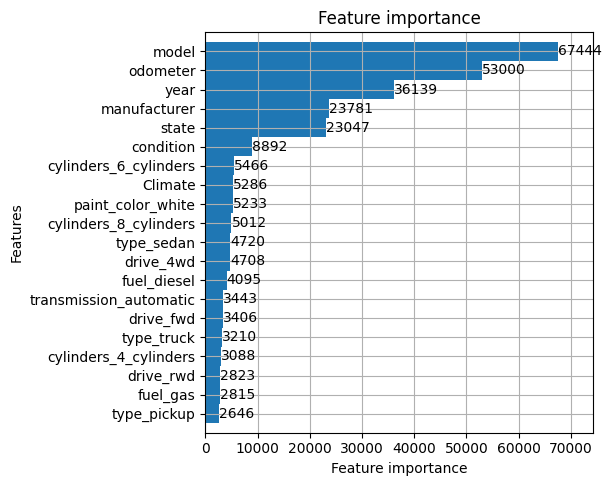

In [162]:
fig =  plt.figure(figsize = (5,5.2))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 1, max_num_features=20)
# plt.show();
plt.savefig('LGBM_top_important_features.png',bbox_inches = 'tight')
# plt.close()

## Ridge Regression

In [163]:
ridge = RidgeCV(cv = 5)
ridge.fit(train, target)
acc_model(10,ridge,train,test,target,target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [35029.16380572 12291.25444737 30055.53053694 24454.27823706
 26091.71872096]
acc(r2_score) for training =  44.47
acc(relative error) for training = 41.13
acc(rmse) for training = 1041782.96
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 8581.64660078 29794.24545561 21095.25417208  6529.67545298
 12279.87157675]
acc(r2_score) for test = 44.77
acc(relative error) for test = 41.22
acc(rmse) for test = 1041094.63


## Bagging Regressor

In [164]:
bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(11,bagging,train,test,target,target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [35479.   7114.5 23590.  14249.4 26466.4]
acc(r2_score) for training =  96.71
acc(relative error) for training = 7.24
acc(rmse) for training = 253577.02
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 6429.9 38590.  11202.4  7403.3  7776.4]
acc(r2_score) for test = 82.63
acc(relative error) for test = 17.74
acc(rmse) for test = 583840.9


## Extra Trees Regressor

In [165]:
etr = ExtraTreesRegressor()
parameters = {
    'n_estimators' : [60,80,100,500],
    'max_depth': [1,5,10]
}

# etr = GridSearchCV(ExtraTreesRegressor(random_state=41),parameters, cv=5)
etr.fit(train, target)
acc_model(12,etr,train,test,target,target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [29999.  6850. 23590. 13900. 26985.]
acc(r2_score) for training =  99.91
acc(relative error) for training = 0.12
acc(rmse) for training = 42620.68
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 4201.47  38590.    11084.165  7454.82   8338.21 ]
acc(r2_score) for test = 82.85
acc(relative error) for test = 17.06
acc(rmse) for test = 580140.02


## Voting Regressor

In [166]:
# Voting_Reg = VotingRegressor(estimators=[('lin', lin_reg), ('ridge', ridge), ('sgd', sgd)])
Voting_Reg = VotingRegressor(estimators=[('etr', etr), ('random_forest', random_forest)])
# params = {'weights': [(1,1), (1,2),(2,1)]}
# vtr = GridSearchCV(Voting_Reg, params)
# vtr.fit(train, target)
Voting_Reg.fit(train, target)
acc_model(14,Voting_Reg,train,test,target,target_test)
# acc_model(14,vtr,train,test,target,target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [31366.31   7084.18  23545.385 13941.7   27113.12 ]
acc(r2_score) for training =  99.35
acc(relative error) for training = 3.2
acc(rmse) for training = 112792.45
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 4629.07166667 38590.         11420.6725      7106.19
  8365.205     ]
acc(r2_score) for test = 84.52
acc(relative error) for test = 16.32
acc(rmse) for test = 551158.13


In [ ]:
# vtr.best_estimator_

In [167]:
def compute_feature_importance(voting_clf, weights):
    feat_importance = dict()
    for est in voting_clf.estimators_:
        feat_importance[str(est)] = est.feature_importances_
    
    feat_scores = [0]*len(list(feat_importance.values())[0])
    for index, imp_score in enumerate(feat_importance.values()):
        imp_score_with_weight = imp_score * weights[index]
        feat_scores = list(np.add(feat_scores, list(imp_score_with_weight)))
    return feat_scores

In [168]:
voting_df = pd.DataFrame()
voting_df['Feature'] = train.columns
voting_df['Feature Importance'] = compute_feature_importance(Voting_Reg, [1, 1])
voting_df.sort_values('Feature Importance', ascending=False)

,Feature,Feature Importance
0,year,0.759926
4,odometer,0.211443
2,model,0.145282
30,drive_fwd,0.116608
15,fuel_diesel,0.100331
...,...,...
9,cylinders_3 cylinders,0.000415
42,type_offroad,0.000408
22,title_status_missing,0.000353
11,cylinders_5 cylinders,0.000277


In [169]:
## only select top featurs with importance higher than 0.1
voting_df_top = voting_df[voting_df['Feature Importance'] > 0.016]

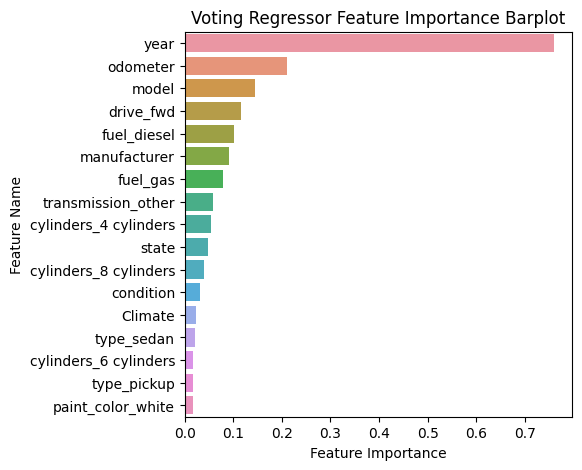

In [170]:
fig =  plt.figure(figsize = (5,5))
#Plot Searborn bar chart
sns.barplot(x = 'Feature Importance', y = 'Feature', data = voting_df_top, order = voting_df_top.sort_values('Feature Importance', ascending=False)['Feature'])
#Add chart labels
plt.title('Voting Regressor Feature Importance Barplot')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
# plt.show();
plt.savefig('votingRegressor_top_important_features.png',bbox_inches = 'tight')
# plt.close()


## Ada Boost

In [171]:
Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test,target,target_test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [30822.91941108 17021.87996906 29242.45727969 21985.58474163
 29242.45727969]
acc(r2_score) for training =  41.25
acc(relative error) for training = 47.14
acc(rmse) for training = 1071613.43
target_test = [ 4000 38590 11995  6999  6500]
ytest = [11151.64284335 34201.66386968 11067.00843604 14095.77057044
 11067.00843604]
acc(r2_score) for test = 40.63
acc(relative error) for test = 47.55
acc(rmse) for test = 1079433.6


## Model Comparison

In [172]:
models = pd.DataFrame({
    'Model': ['LinearRegression', 'LinearSVR', 
              # 'SVR', 
              'MLPRegressor', 'SGDRegressor', 
              'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor', 'LGBM',
              'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'VotingRegressor', 'AdaBoostRegressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [173]:
len(acc_test_rmse)

13

In [174]:
models

,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
0,LinearRegression,4.447000e+01,4.478000e+01,4.113000e+01,4.122000e+01,1.041780e+06,1.041092e+06
1,LinearSVR,-2.315900e+02,-2.304300e+02,1.239300e+02,1.242600e+02,2.545768e+06,2.546604e+06
2,MLPRegressor,6.792000e+01,6.781000e+01,2.870000e+01,2.875000e+01,7.917784e+05,7.947913e+05
3,SGDRegressor,-3.634484e+24,-3.615091e+24,1.332297e+13,1.332007e+13,2.665264e+17,2.663677e+17
4,DecisionTreeRegressor,9.991000e+01,6.946000e+01,1.200000e-01,2.196000e+01,4.261443e+04,7.741784e+05
5,RandomForestRegressor,9.768000e+01,8.431000e+01,6.290000e+00,1.656000e+01,2.131608e+05,5.548417e+05
6,XGBRegressor,8.362000e+01,8.141000e+01,1.925000e+01,2.031000e+01,5.659450e+05,6.023641e+05
7,LGBM,8.874000e+01,8.506000e+01,1.575000e+01,1.757000e+01,4.693419e+05,5.399427e+05
8,RidgeRegressor,4.447000e+01,4.477000e+01,4.113000e+01,4.122000e+01,1.041783e+06,1.041095e+06
9,BaggingRegressor,9.671000e+01,8.263000e+01,7.240000e+00,1.774000e+01,2.535770e+05,5.838409e+05


In [ ]:
models.to_csv('tables.csv', index = False)

In [175]:
pd.options.display.float_format = '{:,.2f}'.format

In [176]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
7,LGBM,88.74,85.06,15.75,17.57,"469,341.91","539,942.65"
11,VotingRegressor,99.35,84.52,3.20,16.32,"112,792.45","551,158.13"
5,RandomForestRegressor,97.68,84.31,6.29,16.56,"213,160.77","554,841.72"
10,ExtraTreesRegressor,99.91,82.85,0.12,17.06,"42,620.68","580,140.02"
9,BaggingRegressor,96.71,82.63,7.24,17.74,"253,577.02","583,840.90"
6,XGBRegressor,83.62,81.41,19.25,20.31,"565,945.02","602,364.12"
4,DecisionTreeRegressor,99.91,69.46,0.12,21.96,"42,614.43","774,178.41"
2,MLPRegressor,67.92,67.81,28.70,28.75,"791,778.40","794,791.30"
0,LinearRegression,44.47,44.78,41.13,41.22,"1,041,779.94","1,041,091.89"
8,RidgeRegressor,44.47,44.77,41.13,41.22,"1,041,782.96","1,041,094.63"


In [177]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
11,VotingRegressor,99.35,84.52,3.20,16.32,"112,792.45","551,158.13"
5,RandomForestRegressor,97.68,84.31,6.29,16.56,"213,160.77","554,841.72"
10,ExtraTreesRegressor,99.91,82.85,0.12,17.06,"42,620.68","580,140.02"
7,LGBM,88.74,85.06,15.75,17.57,"469,341.91","539,942.65"
9,BaggingRegressor,96.71,82.63,7.24,17.74,"253,577.02","583,840.90"
6,XGBRegressor,83.62,81.41,19.25,20.31,"565,945.02","602,364.12"
4,DecisionTreeRegressor,99.91,69.46,0.12,21.96,"42,614.43","774,178.41"
2,MLPRegressor,67.92,67.81,28.70,28.75,"791,778.40","794,791.30"
0,LinearRegression,44.47,44.78,41.13,41.22,"1,041,779.94","1,041,091.89"
8,RidgeRegressor,44.47,44.77,41.13,41.22,"1,041,782.96","1,041,094.63"


In [178]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
7,LGBM,88.74,85.06,15.75,17.57,"469,341.91","539,942.65"
11,VotingRegressor,99.35,84.52,3.20,16.32,"112,792.45","551,158.13"
5,RandomForestRegressor,97.68,84.31,6.29,16.56,"213,160.77","554,841.72"
10,ExtraTreesRegressor,99.91,82.85,0.12,17.06,"42,620.68","580,140.02"
9,BaggingRegressor,96.71,82.63,7.24,17.74,"253,577.02","583,840.90"
6,XGBRegressor,83.62,81.41,19.25,20.31,"565,945.02","602,364.12"
4,DecisionTreeRegressor,99.91,69.46,0.12,21.96,"42,614.43","774,178.41"
2,MLPRegressor,67.92,67.81,28.70,28.75,"791,778.40","794,791.30"
0,LinearRegression,44.47,44.78,41.13,41.22,"1,041,779.94","1,041,091.89"
8,RidgeRegressor,44.47,44.77,41.13,41.22,"1,041,782.96","1,041,094.63"


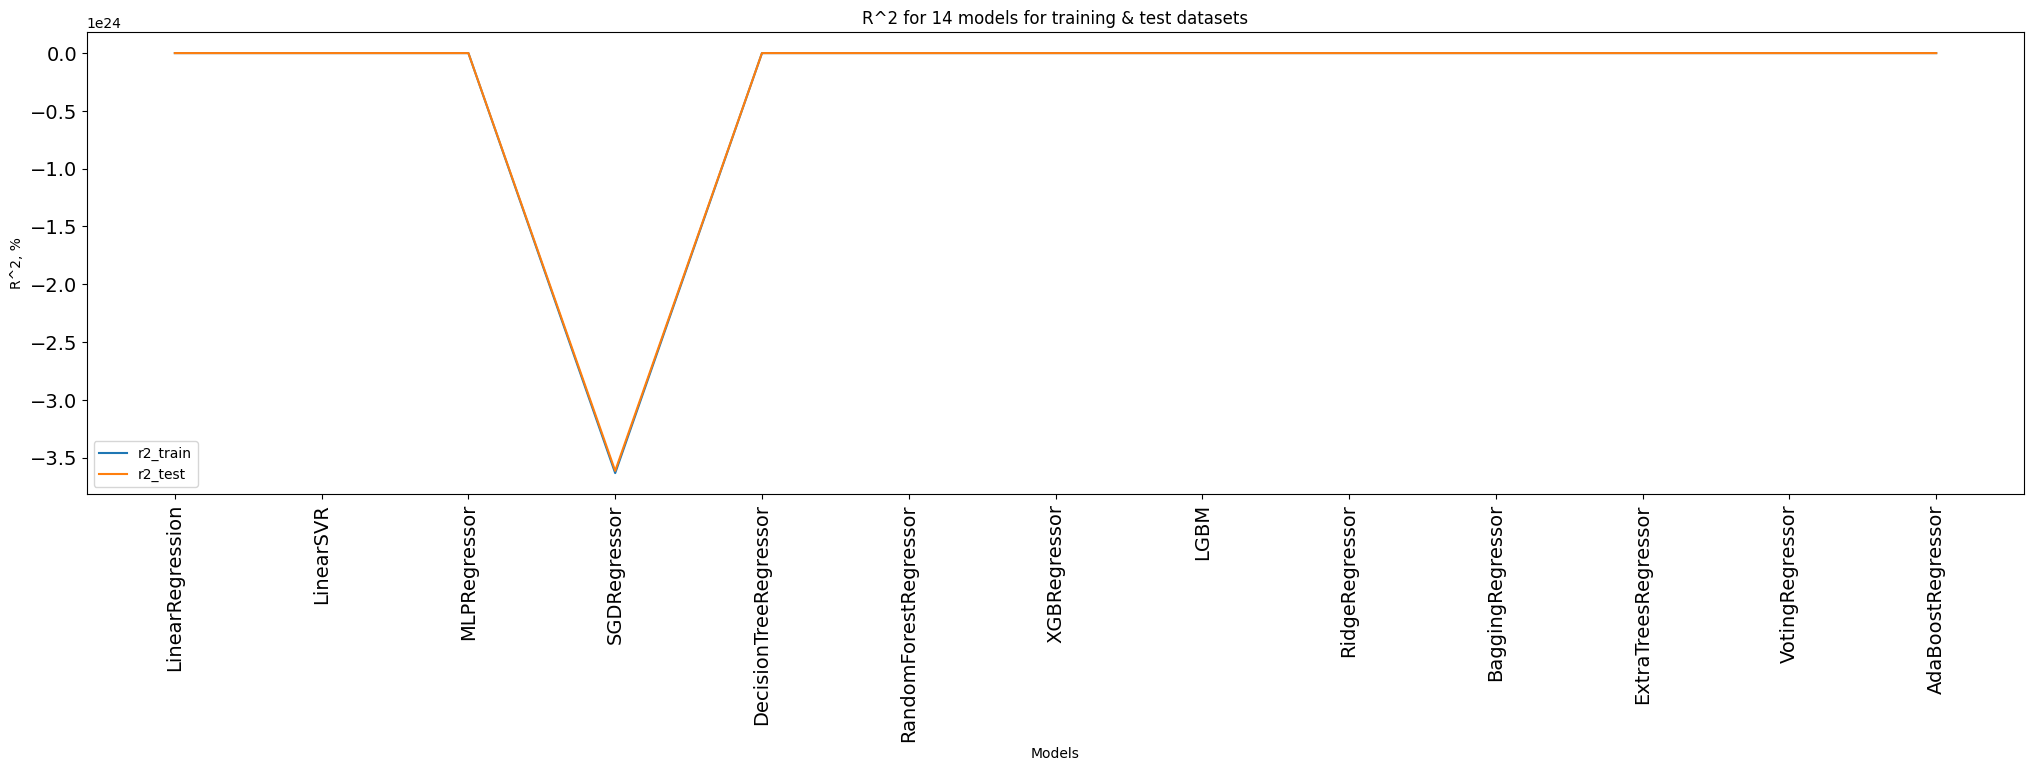

In [179]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R^2 for 14 models for training & test datasets')
plt.xlabel('Models')
plt.ylabel('R^2, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

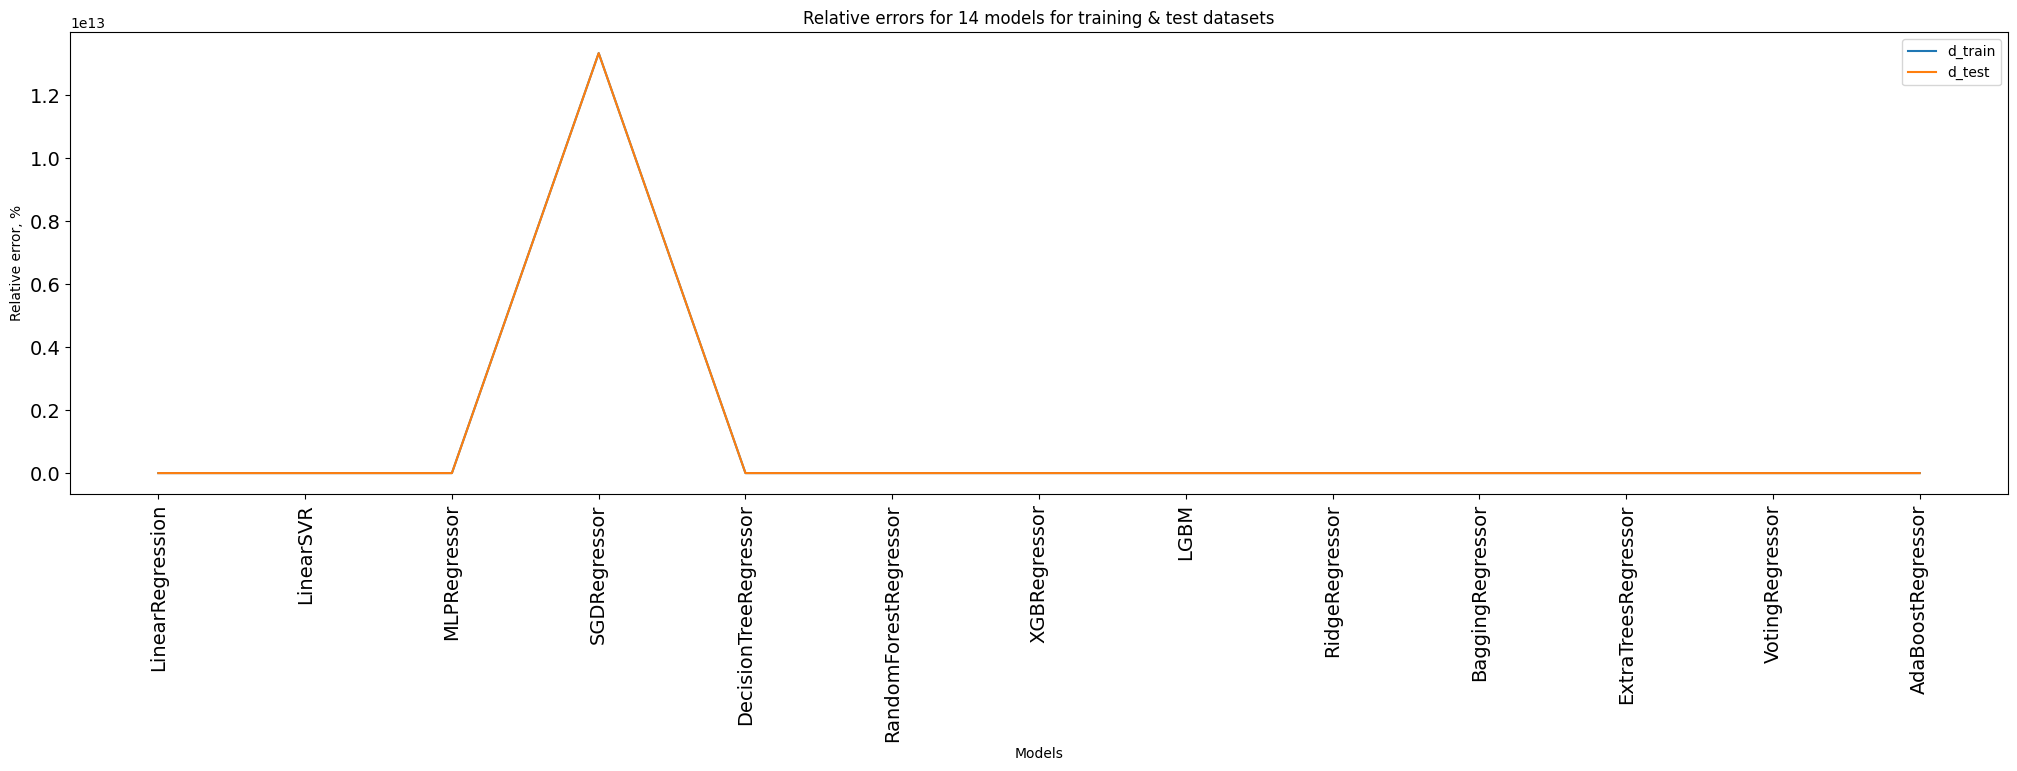

In [180]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 14 models for training & test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

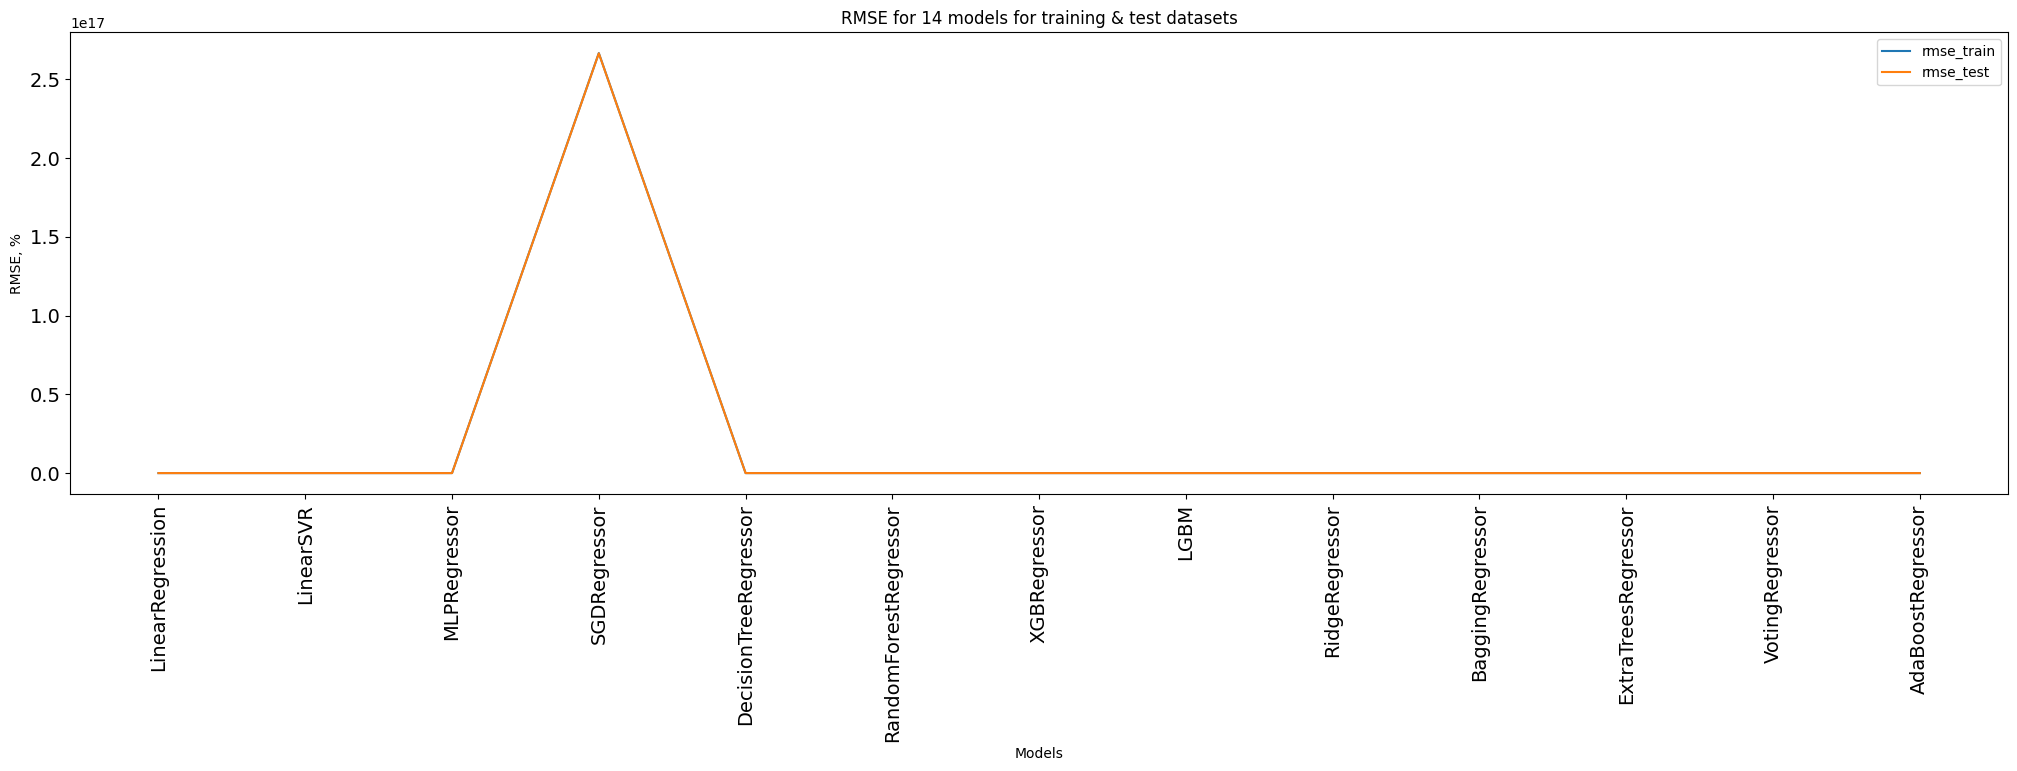

In [181]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 14 models for training & test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

# Prediction

In [ ]:
test0.info()

In [ ]:
test0.head(3)

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
321002,"2,006.00",4,28932,4,7,2,146103,0,0,2,3,0,0,37
170559,"2,018.00",3,7663,2,7,2,13035,0,3,1,3,10,6,17
211245,"2,018.00",13,13017,4,3,2,46275,0,0,0,3,0,5,23


In [ ]:
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [ ]:
lin_reg.fit(train0, train_target0)
lin_reg.predict(testn)[:3]

array([15887.78217742, 34436.85011676, 18968.47754935])

In [ ]:
ridge.fit(train0, train_target0)
ridge.predict(testn)[:3]

array([15887.89428218, 34436.3911515 , 18968.5199704 ])